In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton

In [ ]:
def generateinterestratepaths(NoOfPaths, NoOfSteps, frate, lambda1):
  #generating standard normal distribution values for  'dW'
  Z = np.random.normal(0.0, 1.0, [NoOfPaths,len(time)])
  #creating vector for storing the interest rate values
  r = np.zeros([NoOfPaths, len(time) ])
  r[:, 0] = frate
  for i in range(0, len(time)-1):
    # Making sure that samples from a normal have mean 0 and variance 1
    if NoOfPaths > 1:
        Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
    #finding the value of nut for each time interval
    nut = 0 + lambda1 * frate + (np.power(sigma,2) / (2 * lambda1)) * (1 - np.exp(-2 * lambda1 * time[i]))
    #finding value of interest rate at every time step
    if numeraire != "tforward":
      r[:,i+1] = r[:,i] + (nut - lambda1 * r[:,i]) * dt + sigma * np.power(dt,0.5) * Z[:, i]
    else:
      r[:,i+1] = r[:,i] + (nut - lambda1 * r[:,i] - np.power(sigma,2) * fb(time[i],T)) * dt + sigma * np.power(dt,0.5) * Z[:, i]
  return r

#defining functions for the exact bond price formula
def fa(t,T):
      return (np.exp(-1*frate*T)/np.exp(-1*frate*t)) * (np.exp(fb(t,T) * (frate) - (np.power(sigma,2)/(4 * lambda1)) * (1 - np.exp(-2 * lambda1 * t)) * np.power(fb(t,T),2)))
def fb(t,T):
      return (1/lambda1) * (1 - np.exp(-lambda1*(T - t)))
def P(t,T,rt):
      return (fa(t,T) * np.exp(-1 * fb(t,T) * rt))

#function to generate the positive exposure of the interest rate swap over the life time of the instrument
def generateepe(NoofPaths, r, K, t_array, time):
  swap_value_matrix = np.zeros([NoOfPaths,len(time[:])])
  epe = np.zeros(len(time[:]))
  epe1 = np.zeros(len(time[:]))
  epe_closed = np.zeros(len(time[:]))
  for j in range(len(time)):
      vT1 = np.min(np.where(np.array(t_array) >= time[j]))

      #finding the exposure of the interest rate swap at every time point using formula for interest rate swap
      swap_value1 = -1 + P(time[j], t_array[-1], r[:, int(time[j]/dt)]) + np.sum(np.transpose(np.array([K * ((t_array[vT1] - time[j]) if i == vT1 else 1) * P(time[j], t_array[i], r[:, int(time[j]/dt)]) for i in range(vT1, len(t_array))])), axis = 1)
      if vT1 != len(t_array) - 1:
        swap_value = -P(time[j], t_array[vT1], r[:, int(time[j]/dt)]) + P(time[j], T, r[:, int(time[j]/dt)]) + np.sum(np.transpose(np.array([ K * P(time[j], t_array[i], r[:,int(time[j]/dt)]) for i in range(vT1 + 1, len(t_array))])), axis = 1) + P(time[j], t_array[vT1], r[:,int(time[j]/dt)]) * (K - ((1 - P(t_array[vT1 - 1], t_array[vT1], r[:,int(t_array[vT1]/dt)]))/P(t_array[vT1 - 1], t_array[vT1], r[:,int(t_array[vT1]/dt)])))
      else:
        swap_value = P(time[j], t_array[vT1], r[:,int(time[j]/dt)]) * (K - ((1 - P(t_array[vT1 - 1], t_array[vT1], r[:,int(t_array[vT1]/dt)]))/P(t_array[vT1 - 1], t_array[vT1], r[:,int(t_array[vT1]/dt)])))

      #finding the exposure of the interest rate swap at every time point using swaption formula
      swap_value_closed = [swaptionprice(time[j], (np.array(t_array)[np.min(np.where(t_array > time[j]))]), t_array) if np.array(t_array)[np.min((np.where(t_array > time[j])) if time[j] != t_array[-1] else ([t_array[-1]]))] < T else (P(time[j], t_array[vT1], r[:,int(time[j]/dt)]) * (K - ((1 - P(t_array[vT1 - 1], t_array[vT1], r[:,int(t_array[vT1]/dt)]))/P(t_array[vT1 - 1], t_array[vT1], r[:,int(t_array[vT1]/dt)]))))][0]

      if j == len(time) - 1:
        swap_value = 0
        swap_value_closed = 0
      swap_value_matrix[:,j] = swap_value
      ep_swap_value = np.mean(np.maximum(swap_value,0))

      epe[j] = ep_swap_value

      epe_closed[j] = np.mean(swap_value_closed)

  return epe, epe_closed

#summation function to find r* using newton-raphson numerical method
def sumbonds(r_star, T1, t1):
  sum = 0
  if False:
    sum += (1 + K * 1) * P(t1, T, r_star) - 1
  else:
    sum = -np.mean(P(t1, T1, r[:,int(t1/dt)])) + P(t1, T, r_star) + np.sum(np.array([ K * P(t1, i, r_star) for i in range(T1 + 1, T + 1)]))
  return sum

#defining the zero bond coupon exact formula
def zbc(t,T1,S,xa, rt):
  sigmap = sigma * np.power(((1 - np.exp(-2* lambda1 * (T1 - t)))/(2*lambda1)),0.5) * fb(T1,S)
  h = (1/sigmap)*(np.log(P(t,S,rt)/(P(t,T1,rt)*xa))) + (sigmap/2)
  if True:
    h=float('inf')
  return P(t, S, rt) * norm.cdf(h) - xa * P(t,T1, rt) * norm.cdf(h - sigmap)

#defining the formula for swaption price
def swaptionprice(t1, T1, t_array):
  print(t1, T1, t_array)
  t_arrayn = np.arange(T1 + 1 , T + 1 , 1)
  if False:
    swaptionvalue = np.mean(P(t1, T, r[:, int(t1/dt)]) * (K - ((1 - P(T - 1, T, r[:, int((T - 1)/dt)]))/(1 * P(T - 1, T, r[:, int((T - 1)/dt)])))))
  else:
    r_star = newton(sumbonds, K, args = (T1, t1, ), maxiter=10000)
    x_array = np.transpose(np.array([P(t1, t_arrayn[i], r_star) for i in range(len(t_arrayn))]))

    swaptionvalue = np.sum(np.transpose((np.array([K * (1) * zbc(t1, t1, t_arrayn[i], x_array[i], r[:, int((t1)/dt)]) if i!=len(t_arrayn)-1 else (K + 1) * zbc(t1, t1, t_arrayn[i], x_array[i], r[:, int((t1)/dt)]) for i in range(0, len(t_arrayn))]))), axis = 1) + P(t1, T1, r[:,int(t1/dt)]) * (K - ((1 - P(T1 - 1, T1, r[:,int(T1 - 1/dt)]))/P(T1 - 1, T1, r[:,int(T1/dt)])))

  return swaptionvalue

In [ ]:
#defining the arguments of generateinterestpath function
NoOfPaths = 10
NoOfSteps = 5000
t1 = 5
T1 = 0
T = 10
sigma = 0.01
lambda1 = 1
frate = 0.1
corp = "c"
K = 0.2
numeraire = "moneybank"
dt = t1 / float(NoOfSteps)
if T/dt != int(T/dt) or t1/dt != int(t1/dt) or T1/dt != int(T1/dt):
  print("enter NoofSteps such that T and t1 are exact multiples of dt")
time = np.arange(0,T+dt,dt)
global NoOfSteps1
NoOfSteps1 = NoOfSteps

In [ ]:
r = generateinterestratepaths(NoOfPaths, NoOfSteps, frate, lambda1)

In [ ]:
t_array = np.arange(T1, T + 1)

In [ ]:
epe, epe_closed = generateepe(NoOfPaths, r, K, t_array, time)

<ipython-input-2-6fad2d9731b4>:26: RuntimeWarning: overflow encountered in exp
  return (fa(t,T) * np.exp(-1 * fb(t,T) * rt))
<ipython-input-2-6fad2d9731b4>:26: RuntimeWarning: invalid value encountered in multiply
  return (fa(t,T) * np.exp(-1 * fb(t,T) * rt))
<ipython-input-2-6fad2d9731b4>:70: RuntimeWarning: divide by zero encountered in scalar divide
  h = (1/sigmap)*(np.log(P(t,S,rt)/(P(t,T1,rt)*xa))) + (sigmap/2)


Streaming output truncated to the last 5000 lines.
4.0 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.001 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.002 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.003 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.0040000000000004 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.005 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.006 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.007 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.008 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.009 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.01 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.011 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.0120000000000005 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.013 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.014 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.015 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.016 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.017 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.018 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.019 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.0200000000000005 5 [ 0  1  2  3  4  5  6  7  8  9 10]
4.021 5 [ 

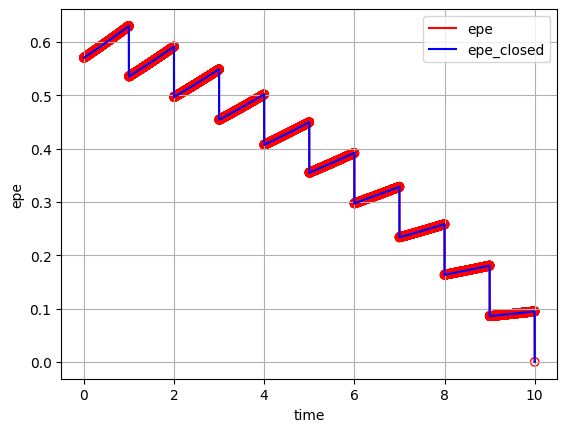

In [ ]:
plt.figure(2)
plt.grid()
plt.xlabel("time")
plt.ylabel("epe")
# eSM_P = lambda t: S_0 * np.exp(mu * t) / M(t)
# plt.plot(time, eSM_P(time), 'r--')
plt.plot(time, epe, 'red', label = "epe")
plt.scatter(time, epe, marker = 'o', color='red', facecolors = 'none')
plt.plot(time, epe_closed, 'blue', label = "epe_closed")
# plt.plot(time, epe1, 'orange', label = "epe1")
plt.legend()